<a href="https://colab.research.google.com/github/KillerStrike17/EVA-5/blob/master/5.%20Code%20Drill/EVA5_Code_Drill_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is Version 4 of the code drill

The main focus here is to get 99.4% accuracy in less than 8k parameters in less than 15 Epochs

## Importing Libraries



In [15]:
import torch 
import torch.nn as nn # All NN Layers
import torch.nn.functional as F # to get loss fucnction
import torch.optim as optim # Optimizer Fucntion
from torchvision import datasets, transforms #Loading Dataset and transform function to perform transformation
from torchsummary import summary # To view summary
%matplotlib inline
import matplotlib.pyplot as plt # To plot graphs
from torch.optim.lr_scheduler import StepLR,OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm


## Data Transformation

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [16]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(fill=(0,),degrees=(-5,5)), # Randomly rotating 50& of the image in the range -5,5
                                       transforms.ToTensor(), # Converting to Tensor
                                       transforms.Normalize((0.1307,),(0.3081,)) # Normalizing the dataset with the mean and std 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Converting to Tensor
                                    transforms.Normalize((0.1307,),(0.3081,))  # Normalizing the dataset using mean and std
                                  ])

## Dataset Cleaning and Train/Test Split

In [17]:
train = datasets.MNIST('./data',train= True,download= True, transform = train_transforms) # Downloading Train set
test = datasets.MNIST('./data',train= False,download= True, transform = test_transforms) # Downloading Test set

## CONSTANTS

In [18]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
DROPOUT_VALUE = 0
EPOCHS = 15

## Data Loading

In [19]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args= dict(shuffle = True, batch_size = BATCHSIZE, num_workers = NUM_OF_WORKER,pin_memory = True) if cuda else dict(shuffle = True, batch_size  = BATCHSIZE_2)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args) # creating train data loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args) # creating test dataloader

CUDA Available True


## The Model

In [26]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=7,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(7),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=7,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 16,out_channels = 12,kernel_size = (1,1),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=12,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(DROPOUT_VALUE)
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5),
        nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)



## Model Parameters
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [27]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              63
              ReLU-2            [-1, 7, 26, 26]               0
       BatchNorm2d-3            [-1, 7, 26, 26]              14
           Dropout-4            [-1, 7, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,008
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             192
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,728
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [28]:


train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [29]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08377432823181152 Batch_id=468 Accuracy=90.47: 100%|██████████| 469/469 [00:23<00:00, 19.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0897, Accuracy: 9744/10000 (97.44%)

EPOCH: 1


Loss=0.10396768897771835 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:23<00:00, 19.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9844/10000 (98.44%)

EPOCH: 2


Loss=0.057783257216215134 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.020552901551127434 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.03250688686966896 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.015061217360198498 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.006502954289317131 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.06535664200782776 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:24<00:00, 19.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9898/10000 (98.98%)

EPOCH: 8


Loss=0.01828046329319477 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.04193935915827751 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.015832308679819107 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:23<00:00, 19.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.0681421086192131 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:24<00:00, 19.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.07995396107435226 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:23<00:00, 19.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.03343558683991432 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:23<00:00, 19.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.03237432613968849 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:23<00:00, 19.65it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy')

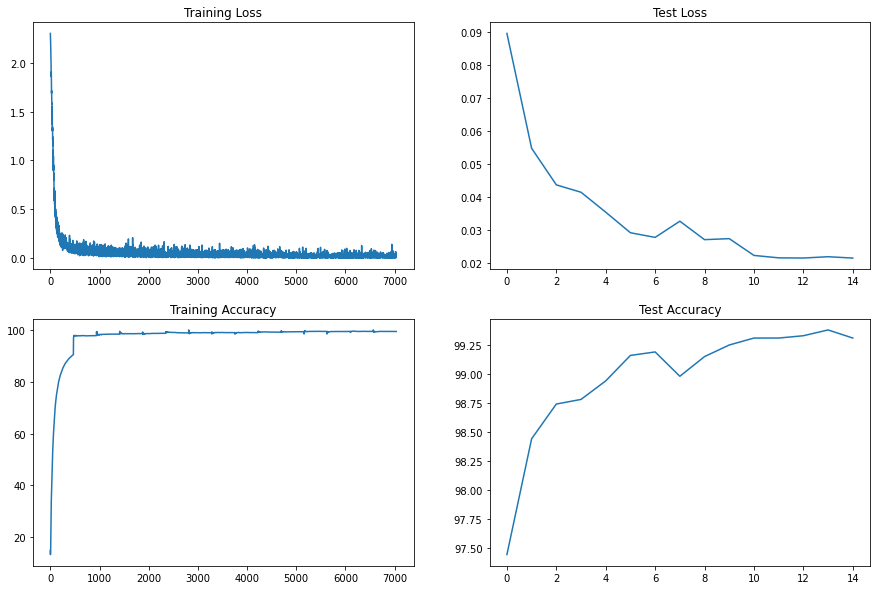

In [30]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [31]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.16528481245040894 Batch_id=468 Accuracy=90.49: 100%|██████████| 469/469 [00:24<00:00, 19.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9803/10000 (98.03%)

EPOCH: 1


Loss=0.0364520289003849 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9836/10000 (98.36%)

EPOCH: 2


Loss=0.10210678726434708 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9855/10000 (98.55%)

EPOCH: 3


Loss=0.11817514896392822 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.05218278244137764 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:24<00:00, 19.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.02400035597383976 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.027861496433615685 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.030019499361515045 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.011645003221929073 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:23<00:00, 19.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.009308362379670143 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:24<00:00, 19.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.013574094511568546 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:24<00:00, 19.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.02363412268459797 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:24<00:00, 19.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.05323414131999016 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:24<00:00, 19.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.01695575937628746 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.03046630322933197 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]



Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)



Text(0.5, 1.0, 'Test Accuracy')

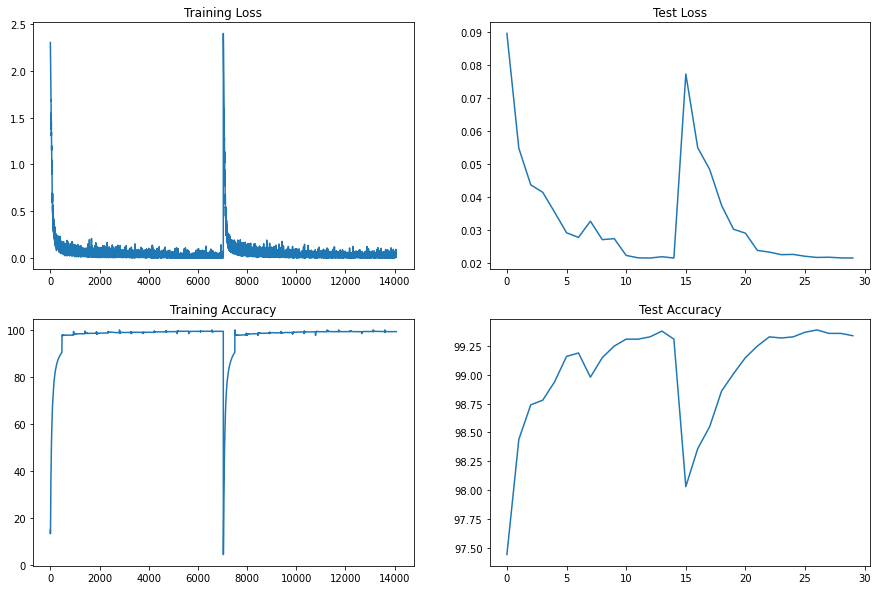

In [32]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [33]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10831943899393082 Batch_id=468 Accuracy=89.94: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0864, Accuracy: 9793/10000 (97.93%)

EPOCH: 1


Loss=0.038067471235990524 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.06627300381660461 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


Loss=0.13418760895729065 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:23<00:00, 19.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.08495844155550003 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.020272618159651756 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.01744152046740055 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9933/10000 (99.33%)

EPOCH: 7


Loss=0.01294676959514618 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:24<00:00, 19.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.008461485616862774 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:24<00:00, 19.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.03743681684136391 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:24<00:00, 19.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH: 10


Loss=0.01670350693166256 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.02221924252808094 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:24<00:00, 19.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.006041666027158499 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.023213794454932213 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.012367854826152325 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]



Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

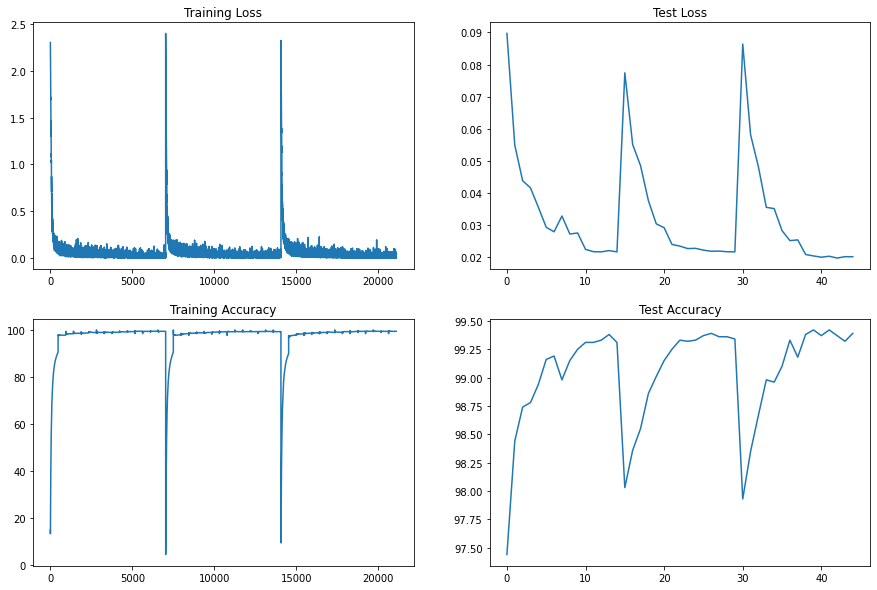

In [34]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")